# Measuring the resolution in an image
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Introduction
The resolution tells the highest spatial frequency you can unambiguously observe in the image. It has an upper limit set by the sampling frequency, but is mostly less. Lower spatial frequencies appear as smooth edges in the image. 

The resolution is a consequence of a series of optical components in your imaging system (penumbra blurring, scintillator, lens, and camera) it could in principle also involve the effect of filtering you applied to the image.

$$h_{system} = h_{penumbra} * h_{scintillator} * h_{lens} * h_{camera} * h_{filters}$$

### What you will learn in this tutorial

### Needed mathematical concepts
- Convolution 
- Fourier transform
- Curve fitting
- Interpolation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import tifffile as tiff
import matplotlib.patches as mpatches
import skimage.filters as flt
import sys
sys.path.append('../00_common/')
import resolutiontools as res
%config InlineBackend.figure_format = 'retina'

In [ ]:
import importlib
importlib.reload(res)

## The principle to measuring the resolution
The resolution can be measured using two main methods
- Using test patterns representing discrete resolutions
- Measuring the width intensity spread from an absorbing edge

<figure>

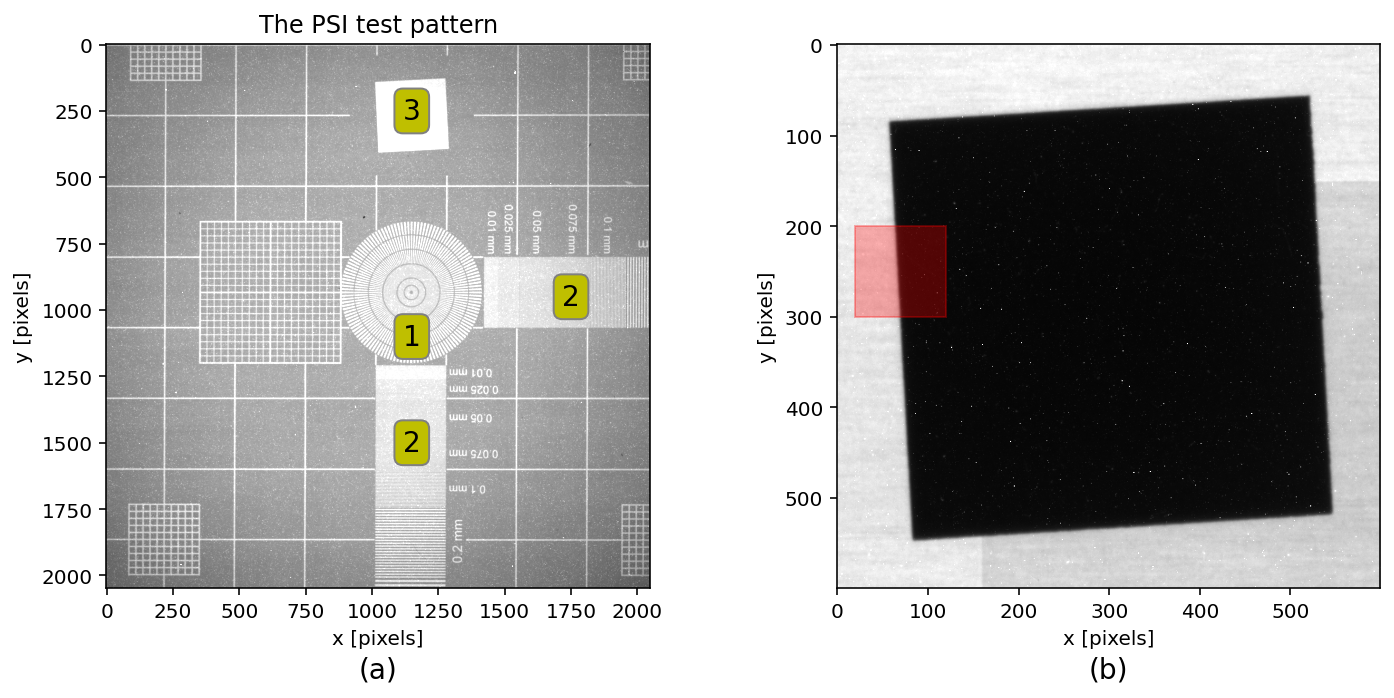

In [379]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
img1 = tiff.imread('../00_common/data/edges/edge20mm_0000.tif')

idx_edge    = 1
idx_pattern = 0
ax[idx_edge].imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax[idx_edge].set_xlabel('x [pixels]')
ax[idx_edge].set_ylabel('y [pixels]');
rect=mpatches.Rectangle((20,200),100,100,fc='r',ec='r',alpha=0.3)
ax[idx_edge].add_patch(rect)

img2 = fits.getdata('data/focus_34mm_60s.fits')
ax[idx_pattern].imshow(img2,vmin=800,vmax=10000,cmap='gray')
ax[idx_pattern].set_title('The PSI test pattern')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[idx_pattern].text(1150,1100, "1", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,1500, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1750,950, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,250, "3", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].set_xlabel('x [pixels]')
ax[idx_pattern].set_ylabel('y [pixels]');

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

<figcaption align = "center"><b>Figure 1</b> - Items to measure the resolution; (a) a printed test pattern and (b) knife edge made of gadolinum (for neutrons)</figcaption>
</figure>

Figure 1 shows two devices that can be used to measure the resolution. Panel (a) shows a segment of a test pattern device with different features to measure the resolution. 
1. Siemens star. The spatial frequeny of the spokes in decrease as function of the radius. 
2. Line patterns. Blocks of parallel line with given spatial frequency.
3. Straight absorbing edges.

The item in panel (b) is an absorbing item with straight edges.

## Measuring the resolution using test patterns

The test pattern method is limited to the spatial frequencies avaliable in the test pattern.

## Measuring the resolution using edge spread
The method of measuring resolution using is based on the extracting the intensity profile across a high contrast sharp edge. The ideal material to produce such an edge in neutron imaging is gadolinium that thanks to its high attenuation coefficient allows to use a thin sheet. The reason for using a thin sheet is that it can lead to errors in the measurement in case the test object is not perfectly perpendicular to the beam. A deviation will add unsharpnes to the measurement due to different material thicknesses as shown in the figure below.

<br/>
<figure>
<img src="figures/materialthickness.svg" style="width:400px"/>
<br/>  
<figcaption align = "center"><b>Figure 2</b> - Edge response with different material thickness may bias the resolution measurements.</figcaption>
</figure>    
<br/>

The test object should also be slightly rotated (3-6$^{\circ}$) in the image plane to provide a slanted edge to allow better edge sampling. The figure below shows the profiles across different positions along the edge. Here, you can see that the shape varies slightly depending on where the profile is extracted.

<figure>

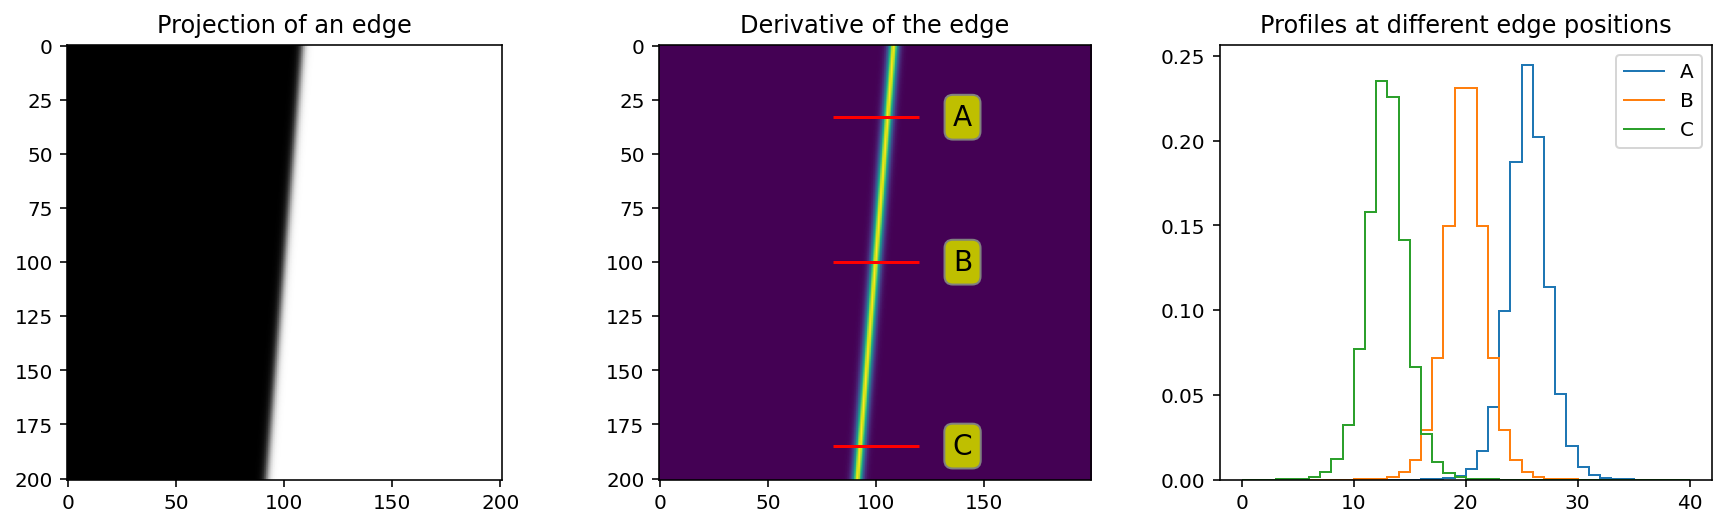

In [380]:
x,y = np.meshgrid(np.linspace(-10,10,201),np.linspace(-10,10,201))
def sigm(x,s) :
    return 1/(1+np.exp(-x/s))

e = sigm(x+0.0834*y,0.1)
de = np.diff(e)
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(e,cmap='gray')
ax[0].set_title('Projection of an edge')
ax[1].imshow(de)
ax[1].set_title('Derivative of the edge')
begin=80
end=120
alpha=1
a = 33
b = 100
c = 185

ax[1].hlines([a,b,c],xmin=begin,xmax=end,color='red')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[1].text(end+20,a, "A", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(end+20,b, "B", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[1].text(end+20,c, "C", ha="center", va="center", size=14,
        bbox=bbox_props)

pA = de[a, begin:end]
pB = de[b,begin:end]
pC = de[c,begin:end]


ax[2].stairs(pA,label='A',alpha=alpha)
ax[2].stairs(pB,label='B',alpha=alpha)
ax[2].stairs(pC,label='C',alpha=alpha)
ax[2].legend()
ax[2].set_title('Profiles at different edge positions');

<figcaption align = "center"><b>Figure 3</b> - An edge and its profiles. The profile shape varies with the position.</figcaption>
</figure>

### Extracting a line spread profile from an edge image
We need to sample several positions along the edge to take advantage of the slanted edge and even achive subpixel accuracy. This must be done carefully using the distance to the edge. There are different methods to do the edge extraction. Among others thresholding and using the distance transform. Here, we will use the method described in the pixel size tutorial to fit a straight line to the edge and compute the average intensity at each distance from the edge.

In [381]:
from scipy.signal import savgol_filter as savgol
x = img1[200:300,20:120]
#x = img2[200:400,950:1070]
p,pos = res.edgeProfile(flt.median(x),decimals=1)
dp    = -savgol(p,21,2,1) # computes the derivative of the edge (the sign is only to flip the curve)

<figure>

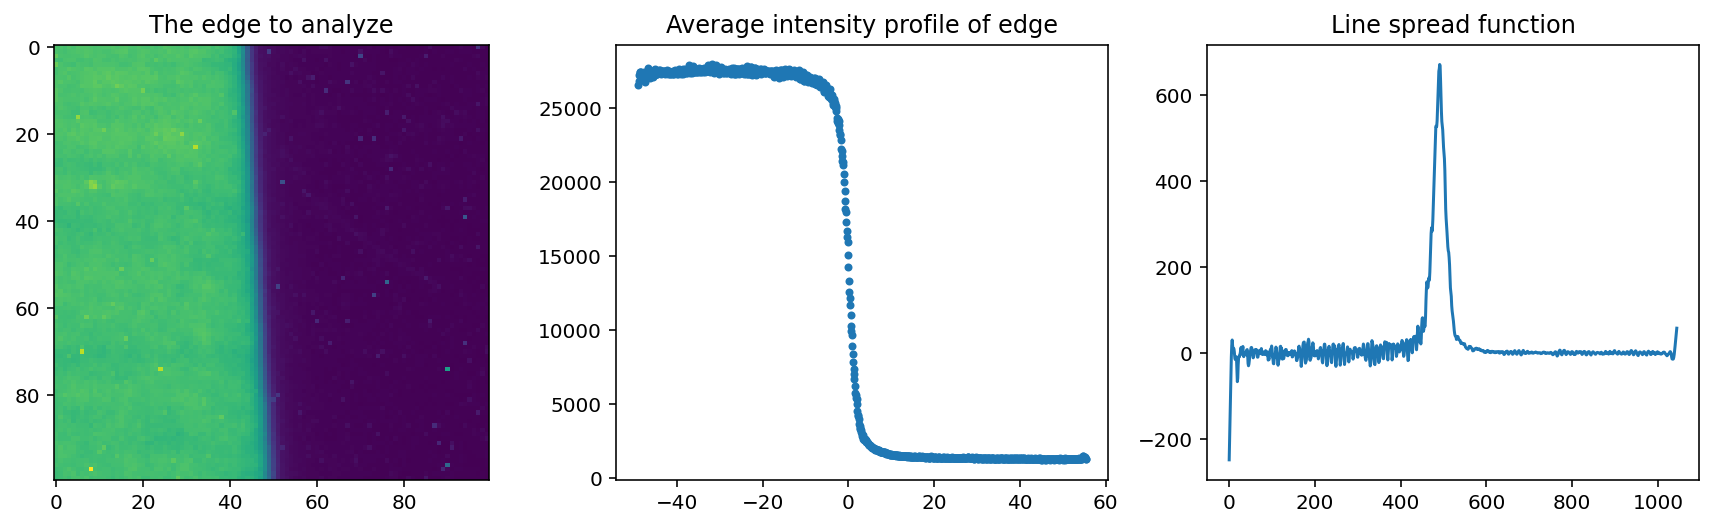

In [382]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax=ax.ravel()
ax[0].imshow(x)
ax[0].set_title('The edge to analyze')
ax[1].plot(pos,p,'.')
ax[1].set_title('Average intensity profile of edge')
ax[2].plot(-savgol(p,11,2,1));
ax[2].set_title('Line spread function');

<figcaption align = "center"><b>Figure 4</b> - edge profile form figure 1b.</figcaption>
</figure>

In [384]:
from scipy.optimize import curve_fit

vc, cov  = curve_fit(res.V2, pos, dp, p0=[1,1,0,4000])
gc, cov  = curve_fit(res.G2, pos, dp, p0=[1,0,4000])

<figure>

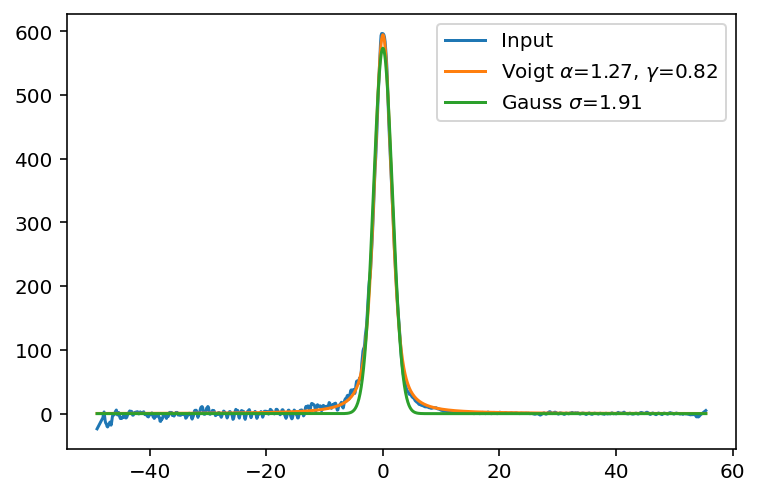

In [385]:
fig,ax=plt.subplots(1,figsize=(6,4))
ax.plot(pos,dp,label='Input')
ax.plot(pos,res.V2(pos,vc[0],vc[1],vc[2],vc[3]),label=r'Voigt $\alpha$={0:0.2f}, $\gamma$={1:0.2f}'.format(vc[0],vc[1]))
ax.plot(pos,res.G2(pos,gc[0],gc[1],gc[2]),label='Gauss $\sigma$={0:0.2f}'.format(gc[0]))
ax.legend();

<figcaption align = "center"><b>Figure 5</b> - Fitting Gaussian and Voigt functions to the line spread function.</figcaption>
</figure>

### Resolution using full width half maximum (FWHM)

<figure>

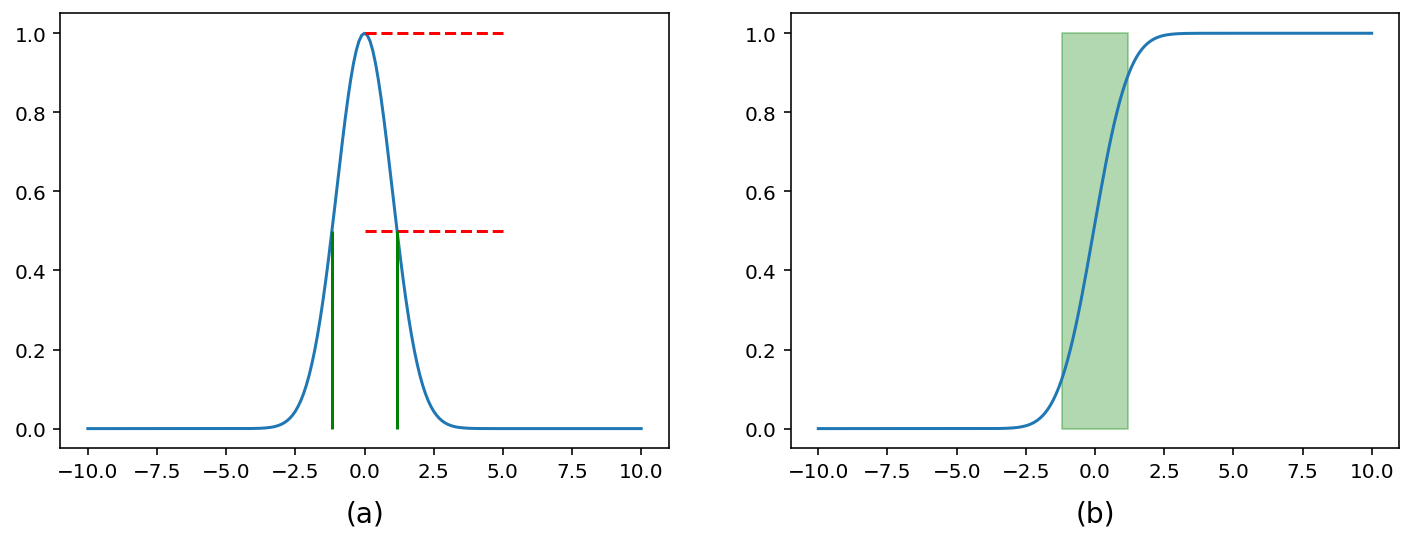

In [415]:
x=np.linspace(-10,10,201)
y=np.exp(-x**2/2)
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x,np.exp(-x**2/2))
ax[0].hlines([0.5,1],xmin=0,xmax=5,linestyles='--',color='red')
hw=np.sqrt(2*np.log(2))
ax[0].vlines([-hw,hw],ymin=0,ymax=0.5,color='green')
ax[1].plot(x,np.cumsum(y)/y.sum())
ax[1].fill_between(x=[-hw,hw],y1=[0,0],y2=[1,1],color='green',alpha=0.3);

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

<figcaption align = "center"><b>Figure 6</b> - FWHM positions on the edge.</figcaption>
</figure>

In [392]:
FWHM = res.FWHM_Voigt(vc)
print("FWHM = {0:0.2f} pixels".format(FWHM))

FWHM = 3.96 pixels


In [393]:
pixelSize = 0.043  
print("FWHM = {0:0.2f} mm".format(FWHM*pixelSize))

FWHM = 0.17 mm


## The Modulation Transfer Function (MTF)

In [419]:
import numpy.fft as fft

pixelSize = 0.043        # [mm] From the pixel size tutorial
stepSize  = pixelSize/10 # we sampled the edge with 0.1 pixels 
period    = stepSize *2  # we need two pixels to describe a 
nyquist   = 1/period     # the frequency is 1/period
level     = 0.1 


MTF = np.abs(fft.fft(dp))
MTF = MTF[:MTF.shape[0]//2]/MTF[0]
w=np.linspace(0,nyquist,MTF.shape[0])

idx=np.argmax(MTF<level)

d=(level-MTF[idx])/(MTF[idx-1]-MTF[idx])
w10 = w[idx]-d*(w[idx]-w[idx-1])

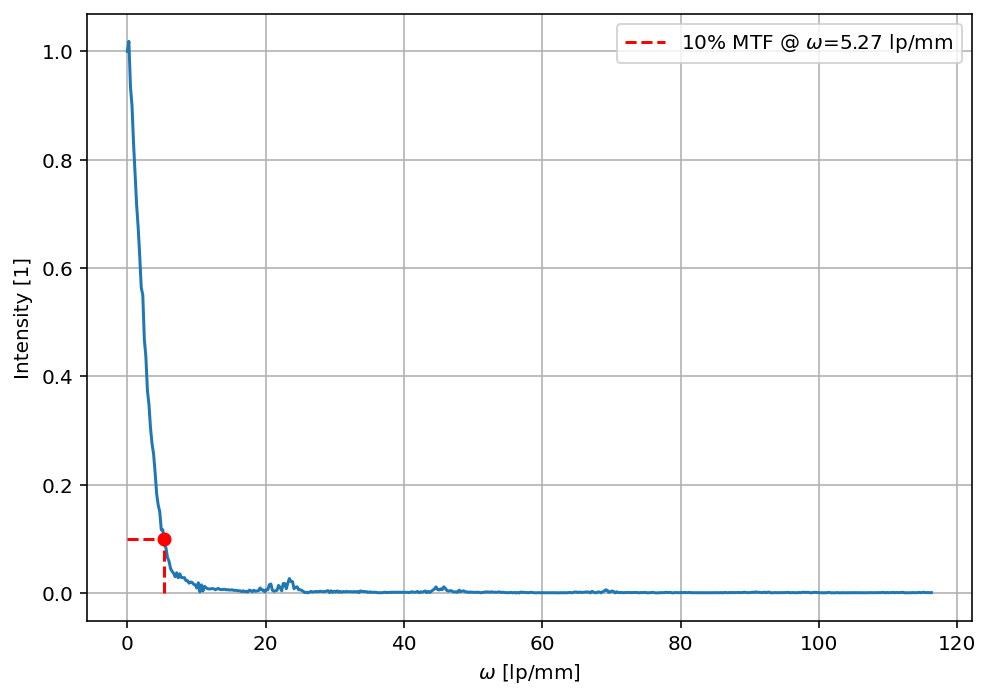

In [418]:
fig,ax = plt.subplots(1,figsize=(7,5))
ax.plot(w,MTF)

ax.set_xlabel('$\omega$ [lp/mm]')
ax.set_ylabel('Intensity [1]')

ax.hlines([level],xmin=w[0],xmax=w10,color='red',linestyles='--')
ax.vlines([w10],ymin=0,ymax=level,color='red',linestyles='--',label='10% MTF @ $\omega$={0:0.2f} lp/mm'.format(w10))
ax.plot(w10,level,'or')
ax.grid(visible=True)
ax.legend();
fig.tight_layout()

## Comparing the methods

## Detection quantum efficiency (DQE)

https://scicoding.com/calculating-power-spectral-density-in-python/

In [ ]:
import importlib
importlib.reload(res)

## Summary